# Import library

In [1]:
import os
import sys
import traci
from sumolib import checkBinary 
import pandas as pd
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# Set the variable
Logic 
1. Number of vehicles in each lane - halting vehicle + non-halting
2. Number of halting vehicles 
3. Propotion of vehicles and number of lane

Index phases from Traffic light logic
- North -> 0 (-E2, 66)
- South -> 2 (-E0, 71)
- West -> 4 (-E1, 45)
- East -> 6 (-E3, 50)

In [2]:
useGui = False
logic = 4
yellowTime = 4
maxPercentProportion = 0.5
cal_halting = 0.4
maximum_green = 60
# จำนวนรถที่รองรับได้ต่อเลน
numCarExpected = 10
vphs = [3000, 3500, 4000, 4500, 5000, 5500]
# vphs = [3000]
num_lane = [3, 4, 2, 2]
edge_name = {0: '-E2', 1: '-E0', 2: '-E1', 3: '-E3'}

standard_time = [66, 71, 45, 50] # north, south, west, east
direction = ['N', 'S', 'W', 'E']

In [3]:
if logic == 1:
    name = 'num_veh'
    graph = 'number of vehicles'
elif logic == 2:
    name = 'num_halting'
    graph = 'number of halting vehicles'
elif logic == 3:
    name = 'proportion'
    graph = 'proportion'

# Function 

In [4]:
def getEdgeHaltingVehicles(edge):
  return traci.edge.getLastStepHaltingNumber(edge)

def getEdgeTotalVehicles(edge):
  return traci.edge.getLastStepVehicleNumber(edge)

def getEdgeWaitingTime(edge):
  return traci.edge.getWaitingTime(edge)

def getEdgeAccumulativeWaitingTime(edge):
  # get all vehicles ID and then get accumulative waiting time for each car ID
  return sum(traci.vehicle.getAccumulatedWaitingTime(vehicle) for vehicle in traci.edge.getLastStepVehicleIDs(edge))

def getCarIdwithDir(carID_dir):
  for i in traci.edge.getLastStepVehicleIDs('-E2'):
    carID_dir['N'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E0'):
    carID_dir['S'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E1'):
    carID_dir['W'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E3'):
    carID_dir['E'].add(i)

def checkFirstCarArrive():
  return len(traci.edge.getLastStepVehicleIDs('E2')) != 0 or len(traci.edge.getLastStepVehicleIDs('E1')) != 0 \
  or len(traci.edge.getLastStepVehicleIDs('E0')) != 0 or len(traci.edge.getLastStepVehicleIDs('E3')) != 0
 
def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

def waiting_time_direction(carID_dir, waiting_time):
  total_time_n = 0;total_time_s = 0
  total_time_w = 0;total_time_e = 0
  for carid in carID_dir['N']:
    total_time_n += waiting_time[carid]
  for carid in carID_dir['S']:
    total_time_s += waiting_time[carid]
  for carid in carID_dir['W']:
    total_time_w += waiting_time[carid]
  for carid in carID_dir['E']:
    total_time_e += waiting_time[carid]

  return total_time_n, total_time_s, total_time_w, total_time_e

def checkLasttCarDepart():
  return len(traci.edge.getLastStepVehicleIDs('-E2')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E1')) == 0 \
  and len(traci.edge.getLastStepVehicleIDs('-E0')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E3')) == 0

## Variable explain

In [5]:
# simulation_data: save time for each logic
simulation_data = pd.DataFrame(columns=['Vehicles Per Hour', 'Accumulated Time', 'Clear Time'])
'''
total_cars_data : save number of each simulation
- All Cars: show the number of cars at each time
- Halting Cars: show the number of haling cars at each time
    {
        '1000': {
            'All Cars': [], 'Halting Cars': []
        }
    }
'''
total_cars_data = {}

'''
traffic_control: save the traffic light time of each simulation
    {
        '1000': Dataframe of direction and time
    }
'''
traffic_control = {}

waiting_time_df = pd.DataFrame(columns=['Vehicles', 'North Waiting Time', 'South Waiting Time', 
                                        'East Waiting Time', 'West Waiting Time',
                                        'Total North Car', 'Total South Car', 'Total East Car', 'Total West Car',
                                        'Total Waiting Time', 'Clear Time'])

# Experiment

In [6]:
for i in vphs:
  net_file = './saint_paul/junction.net.xml'
  route_path = f'./saint_paul/1.0hour/trips/{i}.rou.xml'
  # route_path = './saint_paul/1.0hour/trips/real_world.rou.xml'

  if(useGui): sumoBinary = checkBinary('sumo-gui')
  else: sumoBinary = checkBinary('sumo')
  sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

  traci.start(sumoCmd)

  trafficLightId = traci.trafficlight.getIDList()[0]
  allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
  allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases
  
  switchTime = 0
  # current phase = 3 start with N
  currentPhase = 3
  yellowPhase = True
  latest_time = [66, 71, 45, 50]

  waiting_time = {}
  carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}
  halting_cars = []
  all_car_in_sim = []
  proportion_lane = [1, 1, 1, 1]
  traffic_time = []
  firstTimeArrive = 0
  isArrive = False 

  while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    currentTime = traci.simulation.getTime()

    # start when the first car arrive at the junction
    if not isArrive:
      isArrive = checkFirstCarArrive()
      firstTimeArrive = currentTime
      continue

    # find the next phases to open (yellow and green)
    if currentTime >= switchTime:
      # Swicth to green phase
      if yellowPhase:
        currentPhase = (currentPhase + 1) % 4
        if logic == 1:
          totalVehicles = getEdgeTotalVehicles(edge_name[currentPhase])
          switchTime += int(min(max(15, totalVehicles * cal_halting / num_lane[currentPhase]), 120))
        elif logic == 2:
          totalHaltingVehicles = getEdgeHaltingVehicles(edge_name[currentPhase])
          green_time = int(min(max(15, totalHaltingVehicles / (cal_halting * num_lane[currentPhase])), maximum_green))
          # print(currentTime, direction[currentPhase], green_time)
          switchTime += green_time

          traffic_time.append([direction[currentPhase], green_time])
        elif logic == 3:
          realCars = getEdgeHaltingVehicles(edge_name[currentPhase])

          if realCars == 0:
            green_time = 15
          else:
            expectedCars = num_lane[currentPhase] * numCarExpected
            current_proportion = realCars/expectedCars 
            
            proportion_lane[currentPhase] = current_proportion
            avg_proportion = sum(proportion_lane)/4 if sum(proportion_lane) != 0 else 1

            current_based = current_proportion - 1
            overall_based = current_proportion/avg_proportion - 1

            green_time = int(standard_time[currentPhase] * (1 + max(min(current_based + overall_based, maxPercentProportion), -maxPercentProportion)))

          switchTime += green_time
          traffic_time.append([direction[currentPhase], green_time])

          
        elif logic == 4:
          realCars = getEdgeHaltingVehicles(edge_name[currentPhase])

          if realCars == 0: green_time = 15
          else:
            expectedCars = num_lane[currentPhase] * numCarExpected
            current_proportion = realCars/expectedCars 
            
            proportion_lane[currentPhase] = current_proportion
            avg_proportion = sum(proportion_lane)/4 if sum(proportion_lane) != 0 else 1

            current_based = current_proportion - 1
            overall_based = current_proportion/avg_proportion - 1
            
            green_time = int(latest_time[currentPhase] * (1 + max(min(current_based + overall_based, maxPercentProportion), -maxPercentProportion)))
            green_time = max(green_time, 15)
            green_time = min(green_time, maximum_green)

            # print(current_based, overall_based)
          latest_time[currentPhase] = green_time
         
          switchTime += green_time
          traffic_time.append([direction[currentPhase], green_time])
        
        yellowPhase = False
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2].state)
      # Swicth to yellow phase before switch to green phase
      else:
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2 + 1].state)
        switchTime += yellowTime
        yellowPhase = True

    if checkLasttCarDepart():
      total_clear_time = currentTime
      break
    vehicles = traci.vehicle.getIDList()
    getCarIdwithDir(carID_dir)
    all_car_in_sim.append(len(vehicles))
    halting_cars.append(sum(getEdgeHaltingVehicles(edge) for edge in edge_name.values()))
    
    for vehicle in vehicles:
      vehicle_waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle)
      if(vehicle not in waiting_time):
        waiting_time[vehicle] = vehicle_waiting_time
      else:
        waiting_time[vehicle] = max(vehicle_waiting_time, waiting_time[vehicle])

 
  wt_n, wt_s, wt_w, wt_e = waiting_time_direction(carID_dir=carID_dir, waiting_time=waiting_time)
  total_waiting_time = wt_n + wt_s + wt_w + wt_e
  carID_dir
  waiting_time_df.loc[len(waiting_time_df.index)] = [i, wt_n, wt_s, wt_e, wt_w, 
                                                     len(carID_dir['N']),len(carID_dir['S']),len(carID_dir['E']),len(carID_dir['W']),
                                                     total_waiting_time, total_clear_time]  
  
  total_cars_data[i] = {'All Cars': all_car_in_sim, 'Halting Cars': halting_cars}
  traffic_control[i] = pd.DataFrame(traffic_time, columns=['Direction', 'Time'])
  simulation_data.loc[len(simulation_data.index)] = [i, total_waiting_time, total_clear_time-firstTimeArrive]  

  print('\n', i, total_waiting_time, total_clear_time)
    
  traci.close()

 Retrying in 1 seconds


Step #2000.00 (1ms ~= 1000.00*RT, ~297000.00UPS, TraCI: 8ms, vehicles TOT 1674 ACT 297 BUF
 3000 101378.0 3843.0
Step #3843.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 3006 ACT 95 BUF 0)                
 Retrying in 1 seconds


Step #3500.00 (1ms ~= 1000.00*RT, ~411000.00UPS, TraCI: 10ms, vehicles TOT 3311 ACT 411 BU


 3500 284242.0 3939.0
Step #3939.00 (1ms ~= 1000.00*RT, ~101000.00UPS, TraCI: 7ms, vehicles TOT 3507 ACT 101 BUF
 Retrying in 1 seconds



 4000 651080.0 4238.0
Step #4238.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 4007 ACT 52 BUF 0)                
 Retrying in 1 seconds



 4500 1324567.0 4699.0
Step #4699.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 4509 ACT 60 BUF 0)                
 Retrying in 1 seconds



 5000 2278157.0 5240.0
Step #5240.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 5005 ACT 26 BUF 0)                
 Retrying in 1 seconds



 5500 3365429.0 5746.0
Step #5746.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 5505 ACT 29 BUF 0)               


In [7]:
sum([len(carID_dir['N']), len(carID_dir['S']), len(carID_dir['W']), len(carID_dir['E'])])

5503

In [8]:
waiting_time_df['Vehicles'] = waiting_time_df['Vehicles'].astype('int')
waiting_time_df

,Vehicles,North Waiting Time,South Waiting Time,East Waiting Time,West Waiting Time,Total North Car,Total South Car,Total East Car,Total West Car,Total Waiting Time,Clear Time
0,3000,28310.0,25078.0,25572.0,22418.0,860.0,910.0,650.0,585.0,101378.0,3843.0
1,3500,82246.0,85689.0,67037.0,49270.0,1001.0,1063.0,758.0,684.0,284242.0,3939.0
2,4000,108451.0,192159.0,230474.0,119996.0,1144.0,1213.0,869.0,779.0,651080.0,4238.0
3,4500,221458.0,315049.0,455502.0,332558.0,1289.0,1363.0,976.0,879.0,1324567.0,4699.0
4,5000,479582.0,518001.0,775421.0,505153.0,1430.0,1513.0,1083.0,977.0,2278157.0,5240.0
5,5500,844982.0,705833.0,1120329.0,694285.0,1573.0,1666.0,1192.0,1072.0,3365429.0,5746.0


# Save Results

In [9]:
# waiting_time_df.to_csv(f'./saint_paul/1.0hour/proportion_latest_0.5_10.csv', index=False)

# Plot graph

### Plot Average Waiting Time per Car

In [10]:
total_car = waiting_time_df['Total North Car'] + waiting_time_df['Total South Car']  + waiting_time_df['Total East Car']+ waiting_time_df['Total West Car']
waiting_time_df['Average North Waiting Time'] = waiting_time_df['North Waiting Time']/waiting_time_df['Total North Car']/60
waiting_time_df['Average South Waiting Time'] = waiting_time_df['South Waiting Time']/waiting_time_df['Total South Car']/60
waiting_time_df['Average East Waiting Time'] = waiting_time_df['East Waiting Time']/waiting_time_df['Total East Car']/60
waiting_time_df['Average West Waiting Time'] = waiting_time_df['West Waiting Time']/waiting_time_df['Total West Car']/60
waiting_time_df['Average Total Waiting Time'] = waiting_time_df['Total Waiting Time']/total_car/60
waiting_time_df

,Vehicles,North Waiting Time,South Waiting Time,East Waiting Time,West Waiting Time,Total North Car,Total South Car,Total East Car,Total West Car,Total Waiting Time,Clear Time,Average North Waiting Time,Average South Waiting Time,Average East Waiting Time,Average West Waiting Time,Average Total Waiting Time
0,3000,28310.0,25078.0,25572.0,22418.0,860.0,910.0,650.0,585.0,101378.0,3843.0,0.548643,0.459304,0.655692,0.638689,0.562274
1,3500,112968.0,125283.0,86398.0,78463.0,1001.0,1063.0,758.0,684.0,403112.0,4076.0,1.880919,1.964299,1.899692,1.911866,1.916296
2,4000,162038.0,319609.0,193898.0,115213.0,1144.0,1213.0,869.0,779.0,790758.0,4228.0,2.360693,4.391440,3.718796,2.464976,3.290712
3,4500,233060.0,487943.0,380056.0,299415.0,1289.0,1363.0,976.0,879.0,1400474.0,4574.0,3.013447,5.966532,6.490027,5.677190,5.178885
4,5000,378684.0,691024.0,658497.0,432980.0,1430.0,1513.0,1083.0,977.0,2161185.0,5090.0,4.413566,7.612073,10.133841,7.386216,7.199630
5,5500,801501.0,891992.0,1081068.0,549204.0,1573.0,1666.0,1192.0,1072.0,3323765.0,5503.0,8.492276,8.923489,15.115604,8.538619,10.066524


In [11]:
wait_df = waiting_time_df[['Vehicles', 'Average North Waiting Time', 'Average South Waiting Time', 'Average East Waiting Time', 'Average West Waiting Time', 'Average Total Waiting Time']]

Text(0, 0.5, 'minutes')

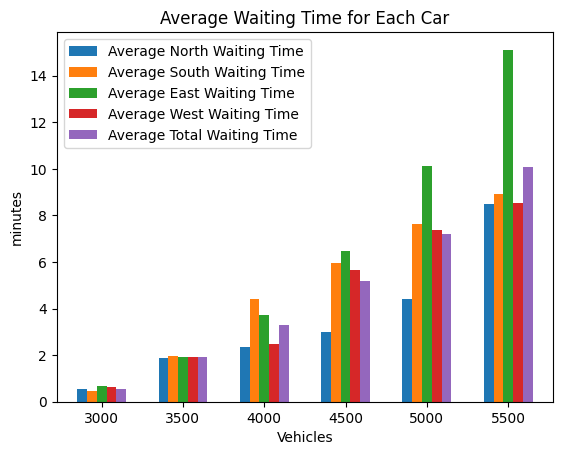

In [12]:
ax = wait_df.plot(x='Vehicles', 
            kind='bar', 
            stacked=False, 
            title=f'Average Waiting Time for Each Car',
            width=0.6,
            # figsize=(12,5)
)
ax.set_xticklabels(wait_df['Vehicles'].astype(int), rotation=0)
plt.ylabel('minutes')

### Plot clear time

In [ ]:
waiting_time_df

In [ ]:
clear_time = waiting_time_df[['Vehicles', 'Clear Time']]
clear_time['Clear Time'] = clear_time['Clear Time']/60 - 60
# ax = clear_time.plot(x='Vehicles',  
#             stacked=False, 
#             title=f'Average Waiting Time for Each Car',
#             # figsize=(12,5)
# )
clear_time.plot(x='Vehicles', y='Clear Time')

### Number of cars

In [ ]:
num = 4000
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

number_of_cars = total_cars_data[num]['Halting Cars'][:clearTime]
time = [t for t in range(len(number_of_cars))]

plt.subplots(figsize=(12, 3))
plt.bar(time, number_of_cars)
plt.title(f'Number of halting Cars in {num} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()

### Green Time

[]

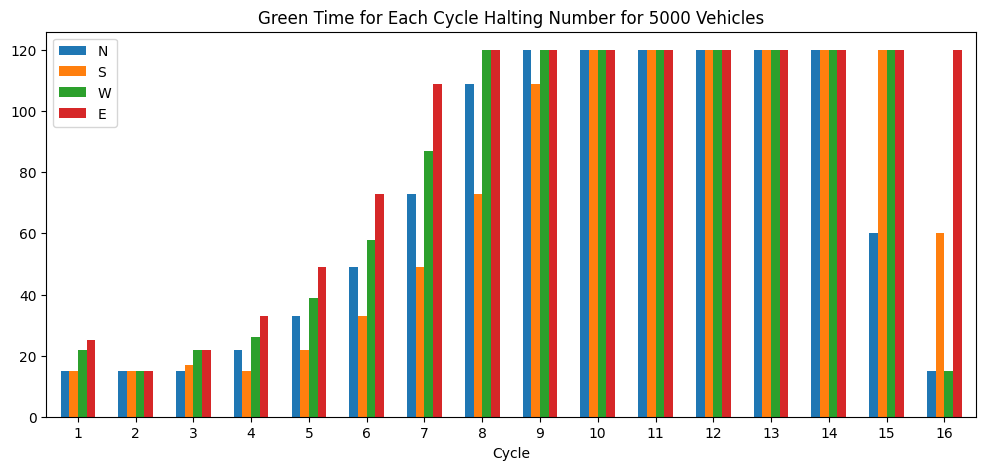

In [22]:
import matplotlib.pyplot as plt

num = 5000

time = traffic_control[num]['Time']
direction = traffic_control[num]['Direction']

num_phase = int(len(direction) / 4)
last_phase = len(direction) % 4

direction_phase = list(direction[:4])

traffic_phase = {}
for d in range(len(direction_phase)):
    traffic_phase[direction_phase[d]] = list(time[d:num_phase*4:4])

df = pd.DataFrame(traffic_phase)
df['Cycle'] = df.index + 1
df = df[['Cycle'] + list(df.columns[:-1].values)]

ax = df.plot(x='Cycle', 
        kind='bar', 
        stacked=False, 
        title=f'Green Time for Each Cycle Halting Number for {num} Vehicles',
        width=0.6,
        figsize=(12,5)
        ) 
ax.set_xticklabels(df['Cycle'], rotation=0)
ax.plot()

In [23]:
df['Total'] = df['N'] + df['S'] + df['W'] + df['E']
df

,Cycle,N,S,W,E,Total
0,1,15,15,22,25,77
1,2,15,15,15,15,60
2,3,15,17,22,22,76
3,4,22,15,26,33,96
4,5,33,22,39,49,143
5,6,49,33,58,73,213
6,7,73,49,87,109,318
7,8,109,73,120,120,422
8,9,120,109,120,120,469
9,10,120,120,120,120,480


In [24]:
sum(df['Total'])/df.shape[0]

306.5

## Waiting Time plot Graph